In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
retail_df = pd.read_csv('../Data_Q4/retail.csv')

In [1]:
retail_df.head()

In [2]:
retail_df.shape

In [3]:
# Check Missing values
retail_df.isnull().sum()

In [4]:
# Drop missing values
retail_df.dropna(inplace=True)

,Transaction_id,Product_id,Description,Quantity,Date,Price,Customer ID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009/12/1 7:45,6.95,13085.0
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009/12/1 7:45,6.75,13085.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009/12/1 7:45,6.75,13085.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009/12/1 7:45,2.10,13085.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009/12/1 7:45,1.25,13085.0


In [5]:
# Check missing values
retail_df.isnull().sum()

(1048575, 7)

In [6]:
retail_df.shape

Transaction_id     48575
Product_id         48575
Description        52906
Quantity           48575
Date               48575
Price              48575
Customer ID       274073
dtype: int64

In [7]:
# Drop duplicates
retail_df.drop_duplicates(inplace=True)

In [8]:
retail_df.shape

Transaction_id    0
Product_id        0
Description       0
Quantity          0
Date              0
Price             0
Customer ID       0
dtype: int64

In [9]:
retail_df['Date'] = pd.to_datetime(retail_df['Date'])

(774502, 7)

In [10]:
# Drop Negative Values
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['Price'] > 0]

In [11]:
Q1 = retail_df['Quantity'].quantile(0.01)
Q3 = retail_df['Quantity'].quantile(0.99)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 过滤掉异常值
retail_df = retail_df[(retail_df['Quantity'] >= lower_bound) & (retail_df['Quantity'] <= upper_bound)]

# 对'Price'字段重复上述步骤
Q1_price = retail_df['Price'].quantile(0.01)
Q3_price = retail_df['Price'].quantile(0.99)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

retail_df = retail_df[(retail_df['Price'] >= lower_bound_price) & (retail_df['Price'] <= upper_bound_price)]

(749040, 7)

In [12]:
def plot_with_outliers(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)

    # 绘制箱形图
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=dataframe[variable])
    plt.title(f'Boxplot of {variable} with Outliers')
    plt.show()

# 对'Quantity'和'Price'字段分别进行绘制
plot_with_outliers(retail_df, 'Quantity')
plot_with_outliers(retail_df, 'Price')

In [13]:
# 查看有多少不同的产品
retail_df['Product_id'].nunique()

可视化

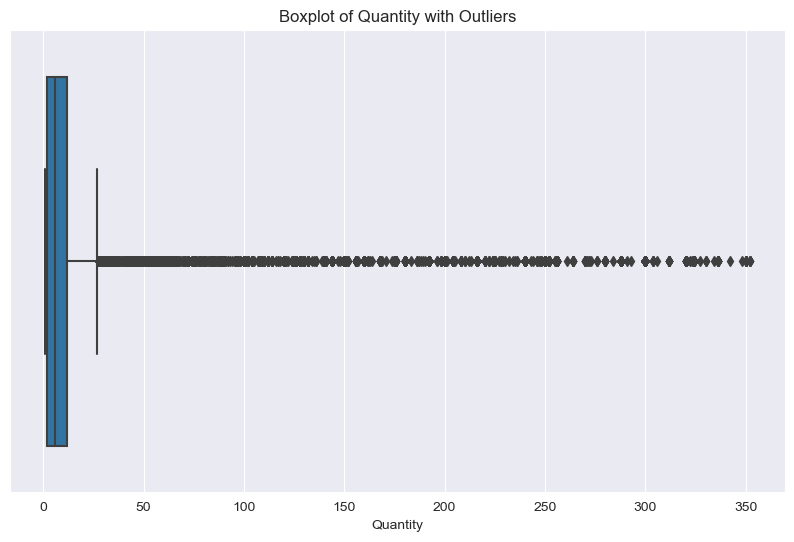

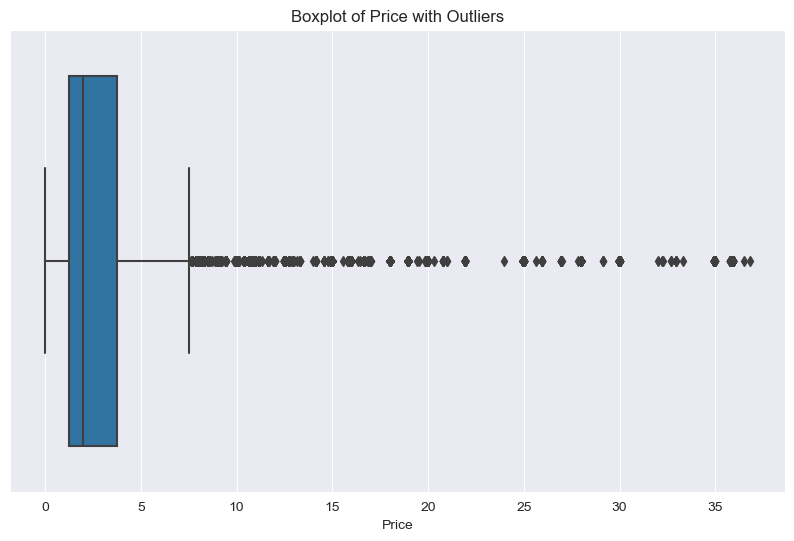

In [15]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Data Preprocessing
# Assuming each row in your DataFrame is a transaction
transactions = retail_df.groupby('Transaction_id')['Product_id'].apply(list)

# Transforming the data into the right format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [21]:
retail_df

Shape of DataFrame:  (728422, 7)
Unique Values in Each Column: 
Transaction_id    34340
Product_id         4598
Description        5242
Quantity            214
Date              32245
Price               424
Customer ID        5728
dtype: int64


,Transaction_id,Product_id,Description,Quantity,Date,Price,Customer ID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0


In [24]:
transactions

Transaction_id
489434    [85048, 79323P, 79323W, 22041, 21232, 22064, 2...
489435                         [22350, 22349, 22195, 22353]
489436    [48173C, 21755, 21754, 84879, 22119, 22142, 22...
489437    [22143, 22145, 22130, 21364, 21360, 21351, 213...
489438    [21329, 21252, 21100, 21033, 20711, 21410, 214...
                                ...                        
576832    [22630, 23497, 23526, 23084, 23318, 22738, 229...
576833    [21108, 22098, 22269, 22266, 22286, 22287, 850...
576834    [23130, 22197, 22909, 22086, 23110, 79321, 231...
576836    [22086, 23567, 22192, 23341, 23342, 22248, 227...
576838    [84347, 22791, 23300, 22485, 22960, 22441, 234...
Name: Product_id, Length: 34340, dtype: object

In [21]:
# Step 2: Finding Frequent Itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

# Step 3: Generating Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Step 4: Filtering Rules
# Filter the DataFrame of rules to find the best ones
rules = rules[(rules['lift'] >= 1) & (rules['confidence'] >= 0.5)]

# Display top 10 rules


In [19]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
19,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.020239,0.027315,0.011386,0.562590,20.596309,0.010833,2.223737,0.971102
21,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.030198,0.027315,0.018084,0.598843,21.923521,0.017259,2.424698,0.984105
22,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.027315,0.030198,0.018084,0.662047,21.923521,0.017259,2.869635,0.981188
24,(ALARM CLOCK BAKELIKE IVORY),(ALARM CLOCK BAKELIKE RED ),0.016337,0.030198,0.011444,0.700535,23.198036,0.010951,3.238446,0.972785
26,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE RED ),0.014560,0.030198,0.010105,0.694000,22.981639,0.009665,3.169288,0.970619
...,...,...,...,...,...,...,...,...,...,...
393,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(REGENCY CAKESTAND 3 TIER),0.016366,0.092749,0.010076,0.615658,6.637899,0.008558,2.360533,0.863481
394,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",(ROSES REGENCY TEACUP AND SAUCER ),0.011619,0.029121,0.010076,0.867168,29.778546,0.009737,7.309074,0.977780
395,"(ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK...",(PINK REGENCY TEACUP AND SAUCER),0.015958,0.020297,0.010076,0.631387,31.107353,0.009752,2.657808,0.983549
399,"(WOODEN PICTURE FRAME WHITE FINISH, WHITE HANG...",(WOODEN FRAME ANTIQUE WHITE ),0.018695,0.049097,0.012056,0.644860,13.134333,0.011138,2.677542,0.941465


## 1. 产品销售量排行
## 1. Top 10 Products by Quantity Sold

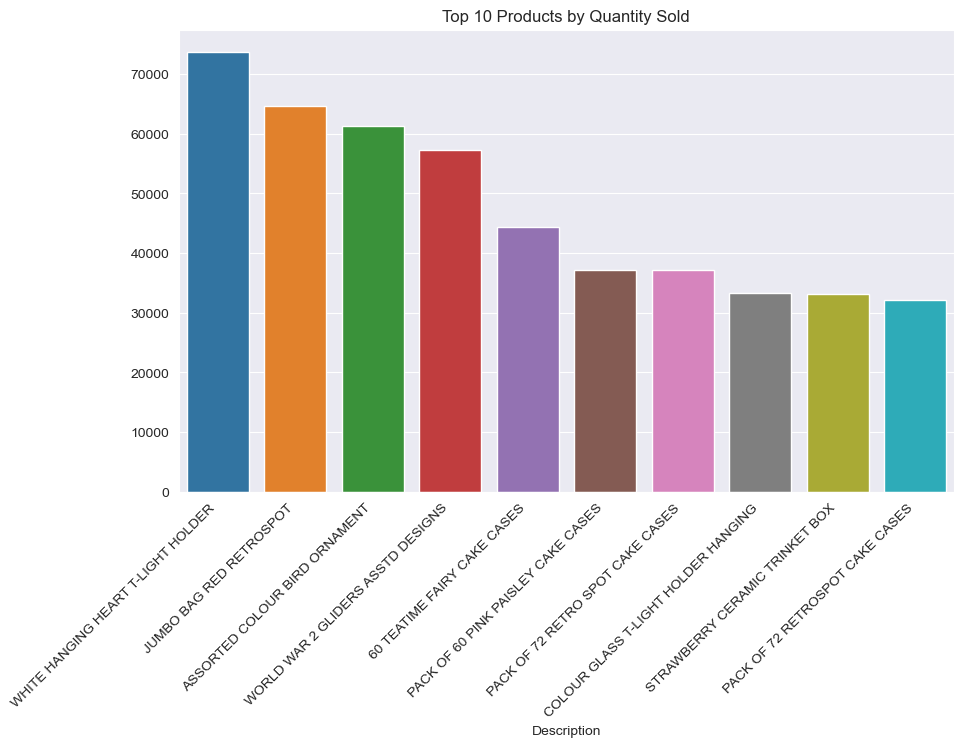

In [28]:
top_products = retail_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Products by Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.show()

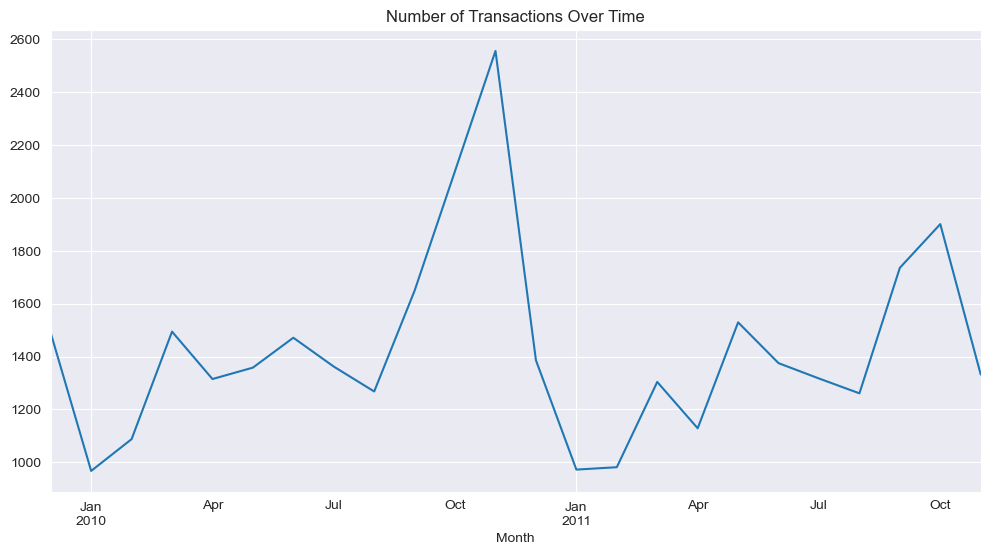

In [29]:
retail_df['Month'] = retail_df['Date'].dt.to_period('M')
transactions_per_month = retail_df.groupby('Month')['Transaction_id'].nunique()
plt.figure(figsize=(12,6))
transactions_per_month.plot(kind='line')
plt.title('Number of Transactions Over Time')
plt.show()

1. 每年每个产品的总销量

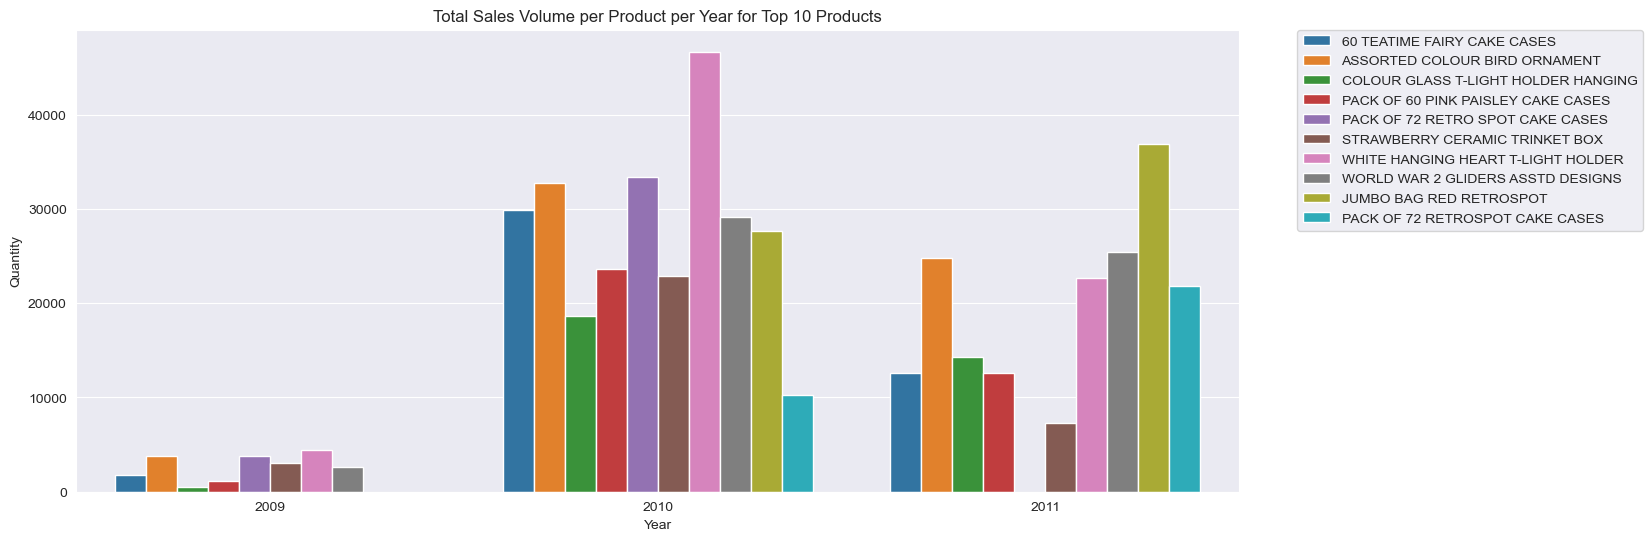

In [28]:
# 选择销量最高的前N个产品
top_products = retail_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).index

# 过滤数据，只保留这些产品
filtered_df = retail_df[retail_df['Description'].isin(top_products)]

# 重新计算销量
sales_volume_per_year = filtered_df.groupby(['Year', 'Description'])['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.barplot(x='Year', y='Quantity', hue='Description', data=sales_volume_per_year)
plt.title('Total Sales Volume per Product per Year for Top 10 Products')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


2. 客户的平均消费及其分布

/var/folders/n7/7084b4k93jb_r5psql_6_sjh0000gn/T/ipykernel_69709/988155514.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(average_spending['Price'])


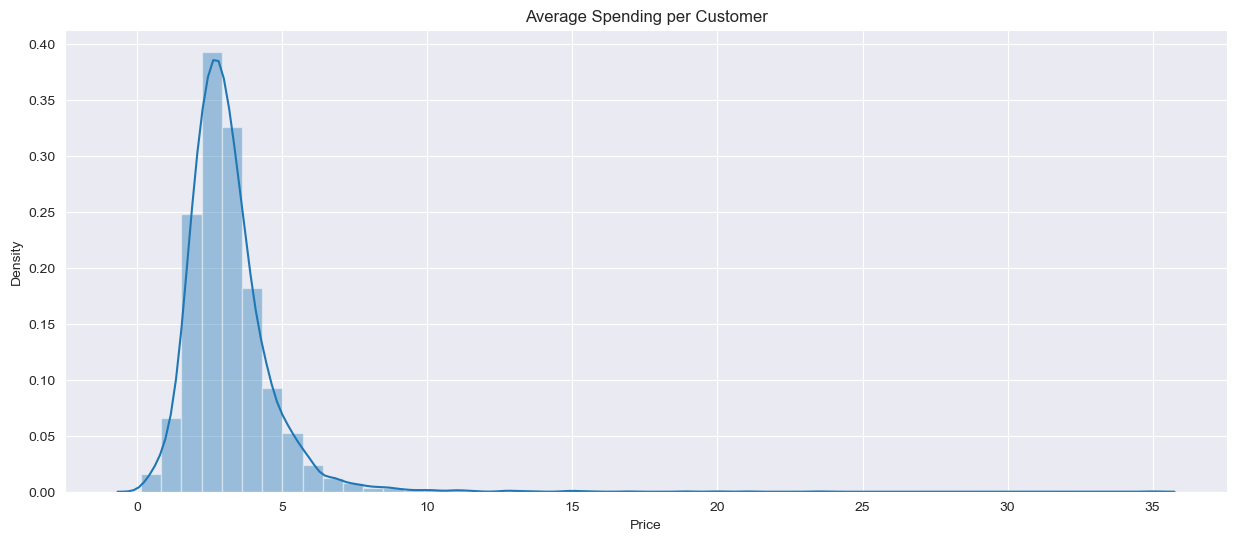

In [29]:
# 计算每位客户的平均消费
average_spending = retail_df.groupby('Customer ID')['Price'].mean().reset_index()

# 绘制分布图
plt.figure(figsize=(15, 6))
sns.distplot(average_spending['Price'])
plt.title('Average Spending per Customer')
plt.show()


3. 最受欢迎的产品

4. 不同时间段的销售趋势

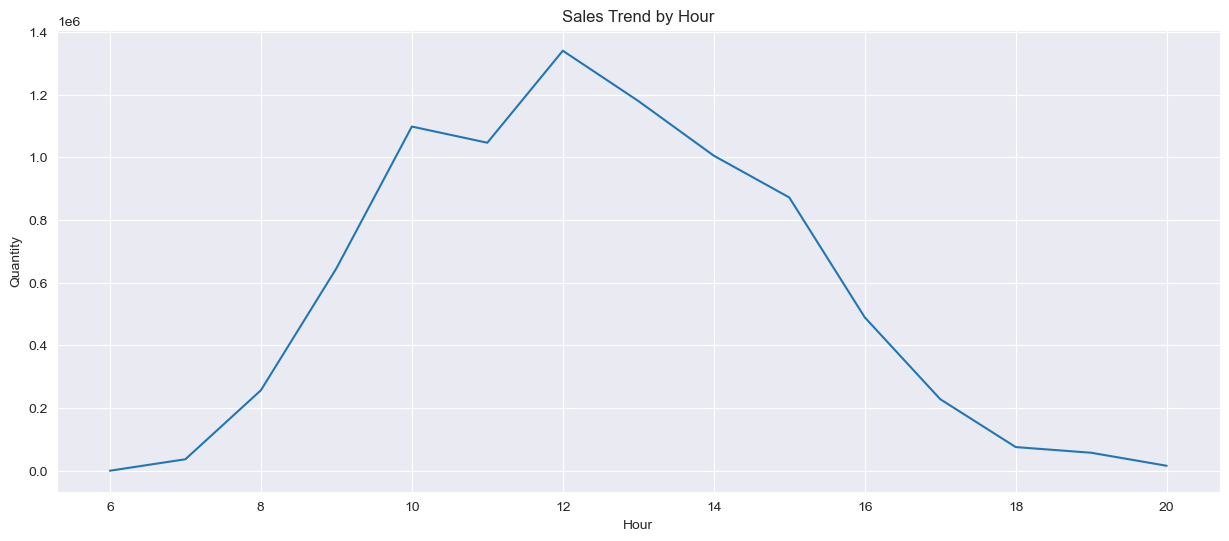

In [31]:
# 添加小时列
retail_df['Hour'] = retail_df['Date'].dt.hour

# 计算每小时的销售量
sales_per_hour = retail_df.groupby('Hour')['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.lineplot(x='Hour', y='Quantity', data=sales_per_hour)
plt.title('Sales Trend by Hour')
plt.show()


5. 不同客户群体的购买偏好

In [32]:
# 你可以根据一些标准（如客户的总消费金额）来定义客户群体
# 例如，将消费在某个范围内的客户划分为一个群体

# 定义客户群体
customer_groups = retail_df.groupby('Customer ID')['Price'].sum()
retail_df['Customer Group'] = pd.qcut(customer_groups, 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 分析每个群体的购买偏好
preference_per_group = retail_df.groupby(['Customer Group', 'Description'])['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.barplot(x='Customer Group', y='Quantity', hue='Description', data=preference_per_group)
plt.title('Purchase Preferences by Customer Group')
plt.show()


ValueError: Image size of 1233x103182 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x600 with 1 Axes>

6. 每月销售趋势
6. Sales Trend by Month

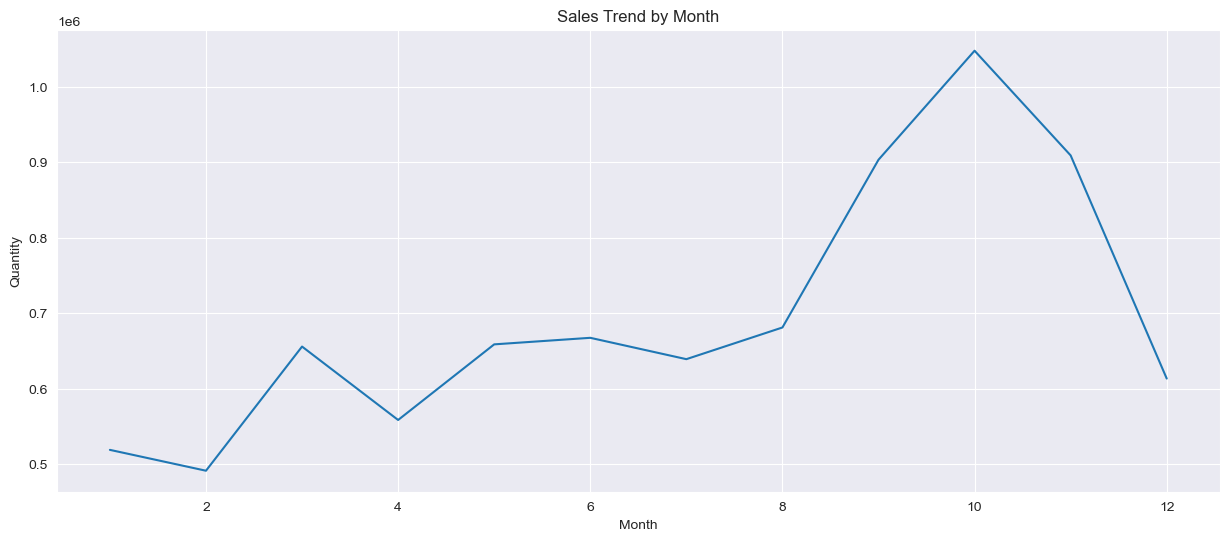

In [33]:
# 添加月份列
retail_df['Month'] = retail_df['Date'].dt.month

# 每月的销售总量
sales_per_month = retail_df.groupby('Month')['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.lineplot(x='Month', y='Quantity', data=sales_per_month)
plt.title('Sales Trend by Month')
plt.show()
